# Federated Learning for Cardiac Risk Prediction

The purpose of this notebook is to predict whether or not a patient has risk of heart disease, while also ensuring the privacy of the patient's health data through federated learning.

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tarfile
import os

In [ ]:
tar = tarfile.open(os.path.join('/content/drive/MyDrive', 'cardiac.tar.xz'))
tar.extractall(path = '/content/drive/MyDrive/Data_Cardi')

In [ ]:
dataDir = '/content/drive/MyDrive/Data_Cardi/cardiac/Train.csv' 



In [ ]:
data = pd.read_csv(dataDir)
data.head()
#data_copy = data


,Gender,Chain_smoker,Consumes_other_tobacco_products,HighBP,Obese,Diabetes,Metabolic_syndrome,Use_of_stimulant_drugs,Family_history,History_of_preeclampsia,CABG_history,Respiratory_illness,UnderRisk
0,1,1,1,0,1,0,0,0,1,0,0,0,no
1,1,0,1,0,1,0,0,0,1,0,0,0,no
2,1,0,1,0,1,0,0,0,1,0,0,0,no
3,1,0,1,0,1,0,0,0,1,0,0,0,no
4,1,0,0,0,0,0,1,1,0,0,0,0,no


In [ ]:
from sklearn import preprocessing
  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
data['UnderRisk']= label_encoder.fit_transform(data['UnderRisk'])
data.head()

,Gender,Chain_smoker,Consumes_other_tobacco_products,HighBP,Obese,Diabetes,Metabolic_syndrome,Use_of_stimulant_drugs,Family_history,History_of_preeclampsia,CABG_history,Respiratory_illness,UnderRisk
0,1,1,1,0,1,0,0,0,1,0,0,0,0
1,1,0,1,0,1,0,0,0,1,0,0,0,0
2,1,0,1,0,1,0,0,0,1,0,0,0,0
3,1,0,1,0,1,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,1,1,0,0,0,0,0


In [ ]:
data_new = np.array(data)
print(data_new)

[[1 1 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 1]
 [2 0 1 ... 0 0 0]
 [1 1 1 ... 0 0 1]]


In [ ]:
print(data_new.shape)

(889, 13)


In [ ]:
def get_random_indexes(n):
    indexes = list(range(n))
    random_indexes = []
    for i in range(n):
        r = np.random.randint(len(indexes))
        random_indexes.append(indexes.pop(r))
    return random_indexes

def get_indexes_for_2_datasets(n, training = 80):
    indexes = get_random_indexes(n)
    train = int(training / 100. * n)
    return indexes[:train], indexes[train:]

matrix = data_new
n_samples, n_dimensions = matrix.shape

train_indexes, test_indexes = get_indexes_for_2_datasets(n_samples)
train_data = matrix[train_indexes]
test_data = matrix[test_indexes]

In [ ]:
print(train_data.shape)

(711, 13)


In [ ]:
print(test_data.shape)

(178, 13)


In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm as tqdm

input_size = 12
learning_rate = 0.001
num_iterations = 20000

class LogisticRegression(torch.nn.Module):

    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_size, 1)
        #self.l1 = torch.nn.Linear(8,6)
        #self.l2 = torch.nn.Linear(6,4)
        #self.l3 = torch.nn.Linear(4,2)
        #self.l4 = torch.nn.Linear(2,1)
        
        self.sigmoid = torch.nn.Sigmoid()
        #self.relu = torch.nn.ReLU()

    def forward(self, x):
        return torch.sigmoid(self.linear(x))
        #out1 = self.relu(self.l1(x))
        #out2 = self.relu(self.l2(out1))
        #out3 = self.relu(self.l3(out2))
        #prediction = self.sigmoid(self.l4(out3))
        #return prediction


In [ ]:
def decide(y):
    return 1. if y >= 0.5 else 0.

decide_vectorized = np.vectorize(decide)

to_percent = lambda x: '{:.2f}%'.format(x)




In [ ]:
def compute_accuracy(model, input, output):
    #print(input.shape, output.shape)
    prediction = model(input).detach().numpy()
    #print(prediction.shape)
    
    #n_samples = prediction.shape[0] + 0.
    prediction = decide_vectorized(prediction)
    equal = prediction.reshape(-1,) == output.detach().numpy().reshape(-1,)
    return 100. * np.mean(equal)



In [ ]:
def get_input_and_output(data):
    input = Variable(torch.tensor(data[:, :12], dtype = torch.float32))
    output1 = Variable(torch.tensor(data[:, 12], dtype = torch.float32))
    #output2 = Variable(torch.tensor(data[:, 7], dtype = torch.float32))
    return input, output1

input, output1 = get_input_and_output(train_data)
test_input, test_output1 = get_input_and_output(test_data)



/usr/local/lib/python3.7/dist-packages/syft/frameworks/torch/hook/hook.py:634: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)


In [ ]:
print(input.shape)

torch.Size([711, 12])


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

diagnosis_title = 'Cardiac Risk'

def plot_graphs(diagnosis_title, losses, accuracies):
    plt.plot(losses)
    plt.title(f"{diagnosis_title} - Training Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Training Loss")
    plt.show()
    plt.plot(accuracies)
    plt.title(f"{diagnosis_title} - Training Accuracy")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy (Percent %)")
    plt.show()
    


In [ ]:
import torch.optim as optim

In [ ]:
def train_model(diagnosis_title, input, output, test_input, test_output):
    model = LogisticRegression()
    criterion = torch.nn.BCELoss(size_average=True)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  
    losses = []
    accuracies = []
    n_samples, _ = input.shape
    for iteration in tqdm(range(num_iterations)):
            optimizer.zero_grad()
            prediction = model(input)
            #print(prediction.size(), output.size())
            loss = criterion(prediction, output)
            loss.backward()
            optimizer.step()
            if iteration % 500 == 0:
            
                train_acc = compute_accuracy(model, input, output)
                train_loss = loss.item()
                losses.append(train_loss)
                accuracies.append(train_acc)
                print('iteration={}, loss={:.4f}, train_acc={}'.format(iteration, train_loss, to_percent(train_acc)))
            #scheduler.step()
    plot_graphs(diagnosis_title, losses, accuracies)
    test_acc = compute_accuracy(model, test_input, test_output)
    print('\nTesting Accuracy = {}'.format(to_percent(test_acc)))
    return model

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
  2%|▏         | 345/20000 [00:00<00:11, 1727.88it/s]

iteration=0, loss=0.6566, train_acc=69.76%


  3%|▎         | 696/20000 [00:00<00:11, 1743.40it/s]

iteration=500, loss=0.5657, train_acc=78.76%


  6%|▌         | 1207/20000 [00:00<00:11, 1707.00it/s]

iteration=1000, loss=0.5375, train_acc=78.76%


  9%|▊         | 1717/20000 [00:01<00:10, 1707.28it/s]

iteration=1500, loss=0.5273, train_acc=78.76%


 11%|█         | 2225/20000 [00:01<00:10, 1689.62it/s]

iteration=2000, loss=0.5232, train_acc=78.76%


 14%|█▎        | 2743/20000 [00:01<00:10, 1654.69it/s]

iteration=2500, loss=0.5211, train_acc=78.76%


 16%|█▌        | 3248/20000 [00:01<00:10, 1638.49it/s]

iteration=3000, loss=0.5200, train_acc=78.76%


 19%|█▉        | 3756/20000 [00:02<00:09, 1663.87it/s]

iteration=3500, loss=0.5191, train_acc=78.76%


 21%|██▏       | 4270/20000 [00:02<00:09, 1692.13it/s]

iteration=4000, loss=0.5185, train_acc=78.76%


 24%|██▍       | 4789/20000 [00:02<00:08, 1698.59it/s]

iteration=4500, loss=0.5178, train_acc=78.76%


 26%|██▋       | 5295/20000 [00:03<00:08, 1656.99it/s]

iteration=5000, loss=0.5173, train_acc=78.76%


 29%|██▉       | 5814/20000 [00:03<00:08, 1645.55it/s]

iteration=5500, loss=0.5167, train_acc=78.76%


 32%|███▏      | 6327/20000 [00:03<00:08, 1670.06it/s]

iteration=6000, loss=0.5161, train_acc=78.76%


 34%|███▍      | 6847/20000 [00:04<00:07, 1713.13it/s]

iteration=6500, loss=0.5156, train_acc=78.76%


 36%|███▌      | 7190/20000 [00:04<00:07, 1680.33it/s]

iteration=7000, loss=0.5151, train_acc=78.76%


 38%|███▊      | 7699/20000 [00:04<00:07, 1680.67it/s]

iteration=7500, loss=0.5146, train_acc=78.76%


 41%|████      | 8216/20000 [00:04<00:06, 1704.26it/s]

iteration=8000, loss=0.5141, train_acc=78.76%


 44%|████▎     | 8724/20000 [00:05<00:06, 1668.26it/s]

iteration=8500, loss=0.5136, train_acc=78.76%


 46%|████▌     | 9223/20000 [00:05<00:06, 1627.01it/s]

iteration=9000, loss=0.5131, train_acc=78.76%


 49%|████▊     | 9740/20000 [00:05<00:06, 1666.58it/s]

iteration=9500, loss=0.5126, train_acc=78.76%


 51%|█████▏    | 10250/20000 [00:06<00:05, 1686.99it/s]

iteration=10000, loss=0.5122, train_acc=78.76%


 54%|█████▍    | 10753/20000 [00:06<00:05, 1646.74it/s]

iteration=10500, loss=0.5117, train_acc=78.76%


 56%|█████▋    | 11268/20000 [00:06<00:05, 1677.20it/s]

iteration=11000, loss=0.5112, train_acc=78.76%


 59%|█████▉    | 11786/20000 [00:07<00:04, 1713.02it/s]

iteration=11500, loss=0.5108, train_acc=78.76%


 62%|██████▏   | 12301/20000 [00:07<00:04, 1666.02it/s]

iteration=12000, loss=0.5104, train_acc=78.76%


 64%|██████▍   | 12808/20000 [00:07<00:04, 1627.82it/s]

iteration=12500, loss=0.5099, train_acc=78.76%


 67%|██████▋   | 13315/20000 [00:07<00:04, 1669.71it/s]

iteration=13000, loss=0.5095, train_acc=78.76%


 69%|██████▉   | 13821/20000 [00:08<00:03, 1662.92it/s]

iteration=13500, loss=0.5091, train_acc=78.76%


 72%|███████▏  | 14337/20000 [00:08<00:03, 1674.88it/s]

iteration=14000, loss=0.5087, train_acc=78.76%


 73%|███████▎  | 14679/20000 [00:08<00:03, 1671.69it/s]

iteration=14500, loss=0.5083, train_acc=78.76%


 76%|███████▌  | 15202/20000 [00:09<00:02, 1704.86it/s]

iteration=15000, loss=0.5079, train_acc=78.76%


 79%|███████▊  | 15717/20000 [00:09<00:02, 1631.32it/s]

iteration=15500, loss=0.5075, train_acc=78.76%


 81%|████████  | 16232/20000 [00:09<00:02, 1670.85it/s]

iteration=16000, loss=0.5071, train_acc=78.76%


 84%|████████▎ | 16749/20000 [00:10<00:01, 1698.45it/s]

iteration=16500, loss=0.5068, train_acc=78.76%


 86%|████████▋ | 17257/20000 [00:10<00:01, 1658.08it/s]

iteration=17000, loss=0.5064, train_acc=78.76%


 89%|████████▉ | 17773/20000 [00:10<00:01, 1679.92it/s]

iteration=17500, loss=0.5060, train_acc=78.76%


 91%|█████████▏| 18286/20000 [00:10<00:01, 1695.20it/s]

iteration=18000, loss=0.5057, train_acc=78.76%


 94%|█████████▍| 18800/20000 [00:11<00:00, 1684.39it/s]

iteration=18500, loss=0.5053, train_acc=78.76%


 97%|█████████▋| 19315/20000 [00:11<00:00, 1686.54it/s]

iteration=19000, loss=0.5050, train_acc=78.76%


 99%|█████████▉| 19828/20000 [00:11<00:00, 1695.66it/s]

iteration=19500, loss=0.5046, train_acc=78.76%


100%|██████████| 20000/20000 [00:11<00:00, 1669.71it/s]


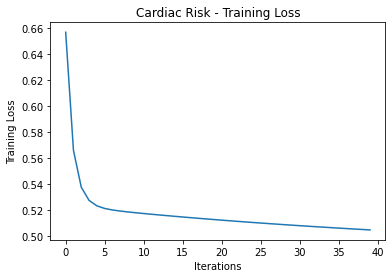

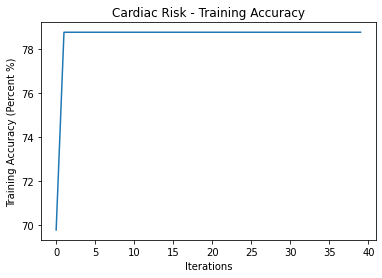


Testing Accuracy = 78.09%


In [ ]:
model = train_model(diagnosis_title, input, output1.view(-1,1), test_input, test_output1)

## Implementing Federatedd Learning using FedAvg algorithm

In [ ]:
assert True is True

In [ ]:
!pip install syft=="0.2.2a1"
!pip install syft_proto=="0.1.1a1.post17"

     |████████████████████████████████| 337kB 20.3MB/s 
     |████████████████████████████████| 532kB 50.3MB/s 
     |████████████████████████████████| 10.2MB 22.0MB/s 
     |████████████████████████████████| 1.8MB 40.6MB/s 
     |████████████████████████████████| 773.1MB 22kB/s 
     |████████████████████████████████| 112kB 54.8MB/s 
     |████████████████████████████████| 71kB 10.3MB/s 
     |████████████████████████████████| 2.1MB 41.7MB/s 
     |████████████████████████████████| 71kB 11.3MB/s 
     |████████████████████████████████| 61kB 8.7MB/s 
     |████████████████████████████████| 61kB 9.7MB/s 
  Created wheel for zstd: filename=zstd-1.5.0.2-cp37-cp37m-linux_x86_64.whl size=1672583 sha256=c98250d924b96669e8a95aa18d83ae48b74952f776ce2d522d11ad755b153adb
  Stored in directory: /root/.cache/pip/wheels/de/94/60/9664cd21af20b4d63068fd1b6271951207947cd1a4085fcf97
  Created wheel for phe: filename=phe-1.4.0-py2.py3-none-any.whl size=37362 sha256=bc9d7717ca6d16a2439a5b83e2adba7f1e9e93

     |████████████████████████████████| 40kB 6.4MB/s 
  Found existing installation: syft-proto 0.5.3
    Uninstalling syft-proto-0.5.3:
      Successfully uninstalled syft-proto-0.5.3


In [ ]:
import sys
import pytest
import syft as sy

In [ ]:
import torch as th
hook = sy.TorchHook(th)
from torch import nn, optim

In [ ]:
n_hospitals = 2
hospitals = []
for i in range(n_hospitals):
    hospital_name = 'hospital{}'.format(i)
    hospital = sy.VirtualWorker(hook, id = hospital_name)
    hospitals.append(hospital)
secure_worker = sy.VirtualWorker(hook, id="secure_worker")

In [ ]:
def get_workers_names(workers):
    return [worker.id for worker in workers]

In [ ]:
def add_and_print_workers(worker, workers):
    print('workers of {} = {}'.format(worker.id, get_workers_names(workers)))
    worker.add_workers(workers)

In [ ]:
for i in range(n_hospitals):
    workers = [hospitals[i2] for i2 in range(n_hospitals) if i2 != i] + [secure_worker]
    add_and_print_workers(hospitals[i], workers)
add_and_print_workers(secure_worker, hospitals)

Worker hospital1 already exists. Replacing old worker which could cause                     unexpected behavior
Worker secure_worker already exists. Replacing old worker which could cause                     unexpected behavior
Worker hospital0 already exists. Replacing old worker which could cause                     unexpected behavior
Worker secure_worker already exists. Replacing old worker which could cause                     unexpected behavior
Worker hospital0 already exists. Replacing old worker which could cause                     unexpected behavior
Worker hospital1 already exists. Replacing old worker which could cause                     unexpected behavior


workers of hospital0 = ['hospital1', 'secure_worker']
workers of hospital1 = ['hospital0', 'secure_worker']
workers of secure_worker = ['hospital0', 'hospital1']


In [ ]:
n_samples = train_data.shape[0]
samples_per_hospital = int((n_samples + 0.5) / n_hospitals)
hospital_features = []
hospital_targets1 = []
#hospital_targets2 = []
train_data = th.tensor(train_data, dtype = torch.float32, requires_grad=True)
for i in range(n_hospitals):
    train_data2 = train_data[i * samples_per_hospital:(i + 1) * samples_per_hospital].clone().detach().requires_grad_(True)
    features = train_data2[:, :12].clone().detach().requires_grad_(True)
    targets1 = train_data2[:, 12][:, None].clone().detach() 
    #targets2 = train_data2[:, 7][:, None].clone().detach() 
    hospital_features.append(features.send(hospitals[i]))
    hospital_targets1.append(targets1.send(hospitals[i]))
    #hospital_targets2.append(targets2.send(hospitals[i]))

print(model)

LogisticRegression(
  (linear): Linear(in_features=12, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
def plot_federated_graphs(diagnosis_title, losses, accuracies):
    for i in range(n_hospitals):
        plt.plot(losses[i], label=f'Hospital {i}')
    legend = plt.legend(loc='upper right', shadow=True)
    plt.title(f"{diagnosis_title} - Training Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Training Loss")
    plt.show()
    for i in range(n_hospitals):
        plt.plot(accuracies[i], label=f'Hospital {i}')
    legend = plt.legend(loc='lower right', shadow=True)
    plt.title(f"{diagnosis_title} - Training Accuracy")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy (%)")
    plt.show()
    

In [ ]:
def compute_federated_accuracy(model, input, output):
    prediction = model(input)
    n_samples = prediction.shape[0]
    s = 0.
    for i in range(n_samples):
        p = 1. if prediction[i] >= 0.5 else 0.
        e = 1. if p == output[i] else 0.
        s += e
    return 100. * s / n_samples


In [ ]:
iterations = 500 #2000
worker_iterations = 10

def federated_learning(diagnosis_title, hospital_features, hospital_targets, test_input, test_output):
    model = LogisticRegression()
    criterion = torch.nn.BCELoss(size_average=True)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
    losses = [[] for i in range(n_hospitals)]
    accuracies = [[] for i in range(n_hospitals)]
    for iteration in range(iterations):
        models = [model.copy().send(hospitals[i]) for i in range(n_hospitals)]
        optimizers = [torch.optim.SGD(params = models[i].parameters(), lr = learning_rate) for i in range(n_hospitals)]
        for worker_iteration in range(worker_iterations):
            last_losses = []
            for i in range(n_hospitals):
                optimizers[i].zero_grad()
                prediction = models[i](hospital_features[i])
                loss = criterion(prediction, hospital_targets[i])
                loss.backward()
                optimizers[i].step()
                loss = loss.get().data.item()
                last_losses.append(loss)
        for i in range(n_hospitals):
            losses[i].append(last_losses[i])
            train_acc = compute_federated_accuracy(models[i], hospital_features[i], hospital_targets[i])
            accuracies[i].append(train_acc)
            models[i].move(secure_worker)
        with th.no_grad():
            avg_weight = sum([models[i].linear.weight.data for i in range(n_hospitals)]) / n_hospitals
            model.linear.weight.set_(avg_weight.get())
            avg_bias = sum([models[i].linear.bias.data for i in range(n_hospitals)]) / n_hospitals
            model.linear.bias.set_(avg_bias.get())
        if iteration % 100 == 0:
            losses_str = ['{:.4f}'.format(losses[i][-1]) for i in range(n_hospitals)]
            accuracies_str = [to_percent(accuracies[i][-1]) for i in range(n_hospitals)]
            print('Iteration={}, losses={}, accuracies={}'.format(iteration, losses_str, accuracies_str))
    plot_federated_graphs(diagnosis_title, losses, accuracies)
    test_acc = compute_accuracy(model, test_input, test_output)
    print('\nTesting Accuracy = {}'.format(to_percent(test_acc)))
    return model

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Iteration=0, losses=['0.8584', '0.8761'], accuracies=['21.97%', '20.56%']
Iteration=100, losses=['0.5629', '0.5648'], accuracies=['75.77%', '74.37%']
Iteration=200, losses=['0.5355', '0.5306'], accuracies=['75.77%', '74.93%']
Iteration=300, losses=['0.5312', '0.5231'], accuracies=['78.03%', '78.59%']
Iteration=400, losses=['0.5295', '0.5198'], accuracies=['77.75%', '78.59%']


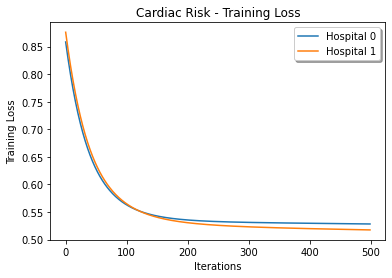

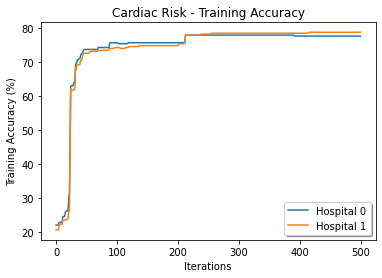


Testing Accuracy = 78.09%


In [ ]:
model = federated_learning(diagnosis_title, hospital_features, hospital_targets1, test_input, test_output1)